In [1]:
# Add the genderComputer library to the path
import os
import sys

path = os.path.join(os.getcwd(), 'vendor', 'genderComputer')
sys.path.insert(0, path)

In [2]:
# Infer the gender of the authors
import analyze_genders

df = analyze_genders.dataframe()

# Find the index of the last author of each paper and add to the original data frame
last_author_index = df.groupby(['paper_id'], sort=False)['author_position'].max().to_frame()
df = df.join(last_author_index, on='paper_id', rsuffix='_last')

In [3]:
# Get the subset of authors which are first and last on a paper
first_authors = df[df['author_position'] == 0]
last_authors = df[df['author_position'] == df['author_position_last']]

In [4]:
def gender_ratio(group):
    """Calculate the fraction of papers in a group authored by females"""
    males = len(group[group['male']])
    unisex = len(group[group['unisex']])
    unknown = len(group[group['unknown']])
    females = len(group[group['female']])
    
    return females / (females + males + unisex + unknown)

# Get the fraction of papers with female authors by conference and year
count_ratio = lambda df: df.groupby(['conf', 'year']).apply(gender_ratio).to_frame('ratio')

all_ratio = count_ratio(df)
first_ratio = count_ratio(first_authors)
last_ratio = count_ratio(last_authors)

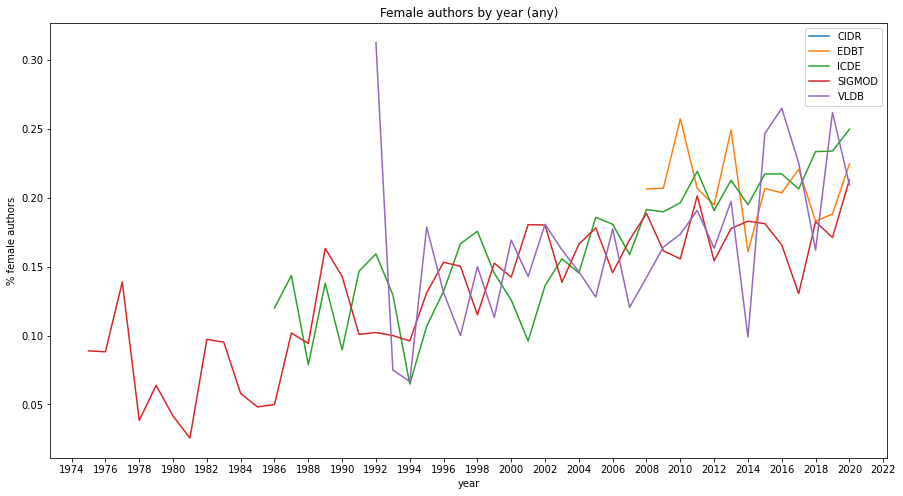

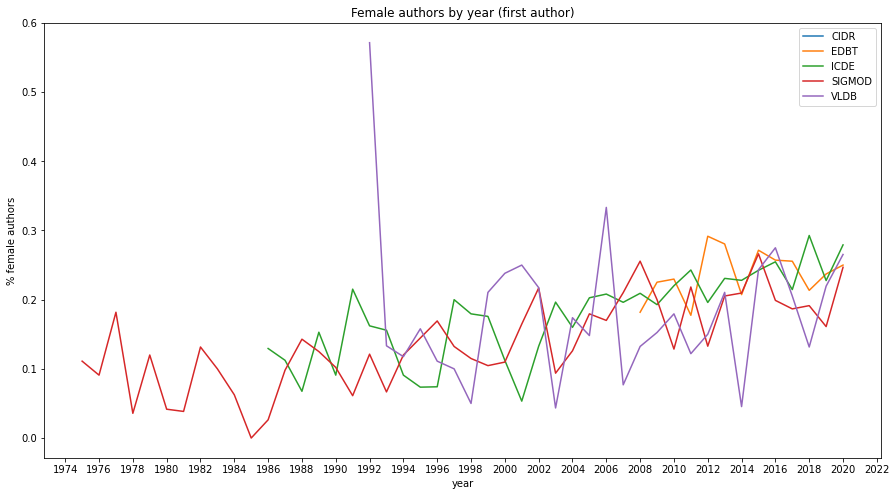

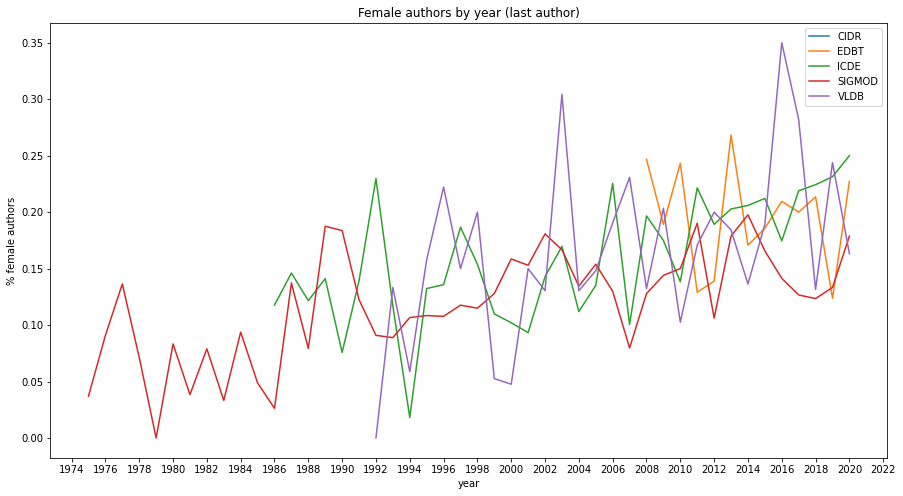

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_authors(df, plot_type):
    fig = df.unstack(level=0).plot(figsize=(15,8), title='Female authors by year (%s)' % plot_type)
    fig.xaxis.set_major_locator(ticker.MultipleLocator(2))
    fig.set_ylabel('% female authors')
    fig.legend([c.split(', ')[1].rstrip(')').upper() for c in fig.get_legend_handles_labels()[1]])

plot_authors(all_ratio, 'any')
plot_authors(first_ratio, 'first author')
plot_authors(last_ratio, 'last author')